In [13]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [14]:
global SMP_RATE
SMP_RATE = 16000

In [15]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [16]:
# fpath = '../../cmu_artic/female_us_slt/' #desktop
# mpath = '../../cmu_artic/male_us_bdl/' #desktop
fpath = '../data/female_us/'
mpath = '../data/male_us/'

In [17]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [18]:
bin_size_x = (2,3)
bin_size_y = (2,3)

In [19]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [20]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

In [21]:
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.batch_size = batch_size
        self.seq_size = self.bin_max*SMP_RATE
        self.shape = (self.batch_size,1,self.seq_size,1)
        self.x_list = mapping.keys()
        self.size = len(self.x_list) #data size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        #get the file names
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #Get the x,y files and pad
        x = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        y = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        for i,(xp,yp) in enumerate(zip(x_path,y_path)):
            _,x_raw=wavfile.read(xp)
            _,y_raw=wavfile.read(yp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)
            y_pad = padTo(y_raw,self.bin_max*SMP_RATE)
            x[i,0,:,0]=x_pad
            y[i,0,:,0]=y_pad
            
        #update cursor positions
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return (x,y)

In [22]:
def prelu(x,name='prelu'):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        alpha = tf.get_variable('alpha',in_shape[-1],
                               initializer=tf.constant_initializer(0.),
                               dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x-tf.abs(x))*.5
        
        return pos + neg

In [254]:
def bn(x,ri=[0,1,2],eps=.0001,scaling=True):
    xshp=x.get_shape().as_list()
    with tf.variable_scope('bn'):
        mu = tf.reduce_mean(x,ri,keep_dims=True)
        sigma = tf.reduce_mean(tf.square(x-mu),ri,keep_dims=True)
        x_hat = (x-mu)/(tf.sqrt(sigma+eps))
        
        if scaling:
            gamma = tf.get_variable('gamma',[xshp[-1]],initializer=tf.truncated_normal_initializer(0,.1))
            beta = tf.get_variable('beta',[xshp[-1]],initializer=tf.constant_initializer(1.))
            y = gamma*x_hat+beta
        else:
            y = x_hat
    return y

In [255]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=32)

In [316]:
g = tf.Graph()
with g.as_default():
    #tf.GraphKeys.VARIABLES = tf.GraphKeys.GLOBAL_VARIABLES
    #try None shapes
    x = tf.placeholder(tf.float32,shape=b.shape)
    y = tf.placeholder(tf.float32,shape=b.shape)

In [317]:
with g.as_default():
    def Dis(x,reuse=False):
        with tf.variable_scope('Discriminator') as scope:
            if reuse:
                scope.reuse_variables()
            #Down Colnvolutions
            #create variables
            with tf.variable_scope('in'):
                # Shape (height,width,inchannels,out_channels)
                #down convolutions operations
                with tf.variable_scope('l1'):
                    dis_conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.1))
                    dis_l1=tf.nn.relu(tf.nn.conv2d(bn(x),dis_conv1,strides=[1,1,2,1],padding='SAME')+dis_b1)
                with tf.variable_scope('l2'):
                    dis_conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.1))
                    dis_l2=tf.nn.relu(tf.nn.conv2d(bn(dis_l1),dis_conv2,strides=[1,1,2,1],padding='SAME')+dis_b2)
                with tf.variable_scope('l3'):
                    dis_conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.1))
                    dis_l3=tf.nn.relu(tf.nn.conv2d(bn(dis_l2),dis_conv3,strides=[1,1,2,1],padding='SAME')+dis_b3)
                with tf.variable_scope('l4'):
                    dis_conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.1))
                    dis_l4=tf.nn.relu(tf.nn.conv2d(bn(dis_l3),dis_conv4,strides=[1,1,2,1],padding='SAME')+dis_b4)
                with tf.variable_scope('l5'):
                    dis_conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.1))
                    dis_l5=tf.nn.relu(tf.nn.conv2d(bn(dis_l4),dis_conv5,strides=[1,1,2,1],padding='SAME')+dis_b5)
                with tf.variable_scope('l6'):
                    dis_conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.1))
                    dis_l6=prelu(tf.nn.conv2d(bn(dis_l5),dis_conv6,strides=[1,1,2,1],padding='SAME')+dis_b6)
                with tf.variable_scope('l7'):
                    dis_conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.1))
                    dis_b7 = tf.get_variable('b7',shape=128,initializer=tf.constant_initializer(0.1))
                    dis_l7=prelu(tf.nn.conv2d(bn(dis_l6),dis_conv7,strides=[1,1,2,1],padding='SAME')+dis_b7)

            dis_last_shape = dis_l7.get_shape()
            dis_es=int(dis_last_shape[2])*int(dis_last_shape[3]) #size of encoding
            dis_last = tf.reshape(bn(dis_l7),[b.batch_size,dis_es])

            #fully connected
            with tf.variable_scope('fc'):
                W_fc = tf.get_variable('W',shape=[dis_es,1],initializer=tf.truncated_normal_initializer(0.1))
                b_fc = tf.get_variable('b',shape=[1],initializer=tf.constant_initializer(1.))

                #D_out = tf.sigmoid(bn(tf.matmul(dis_last,W_fc)+b_fc,ri=[0,1],scaling=True))
                D_out = tf.matmul(dis_last,W_fc)+b_fc
        return D_out

In [318]:
with g.as_default():
    x_logit=Dis(x)
    y_logit=Dis(y,reuse=True)
    
    x_pred = tf.sigmoid(x_logit)
    y_pred = tf.sigmoid(y_logit)
#     x_pred=Dis(x)
#     y_pred=Dis(y,reuse=True)
    
    loss1 = tf.reduce_mean(tf.square(x_pred) +tf.square(x_logit))
    loss2 = tf.reduce_mean(tf.square(y_pred-1.)+tf.square(y_logit-1))
#     loss1 = tf.reduce_mean(tf.log(x_pred))
#     loss2 = tf.reduce_mean(tf.square(y_pred-1.))
    
    #tf.train.
    loss = loss1+loss2
    
    dvars = [e for e in g.get_collection('trainable_variables') if 'Discriminator' in e.name]
    
    #opt = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss1)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.01)
    grad_d,var_d = zip(*optimizer.compute_gradients(loss,var_list=dvars))
    grad_d_clipped ,_= tf.clip_by_global_norm(grad_d,.5)
    opt=optimizer.apply_gradients(zip(grad_d_clipped,var_d))
    #opt = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss)

In [319]:
with g.as_default():
    init = tf.global_variables_initializer()

In [320]:
sess=tf.Session(graph=g)
sess.run(init)
losses = []

In [321]:
x_data,y_data = b.getBatch()
fd = {x:x_data,y:y_data}
sess.run(x_pred,feed_dict=fd)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [322]:
num_steps = 10
save_step = 500*30
for i in tqdm(xrange(num_steps)):
    x_data,y_data = b.getBatch()
    fd = {x:x_data,y:y_data}
    _,l = sess.run([opt,loss],feed_dict=fd)
    losses.append(l)
#     if i % save_step == 0:
#         save_path = saver.save(sess, save_path)

100%|██████████| 10/10 [00:53<00:00,  5.40s/it]


In [323]:
losses

[48112016.0,
 47988088.0,
 47887364.0,
 47836100.0,
 47775500.0,
 47734604.0,
 47639144.0,
 47565464.0,
 47499168.0,
 47429988.0]

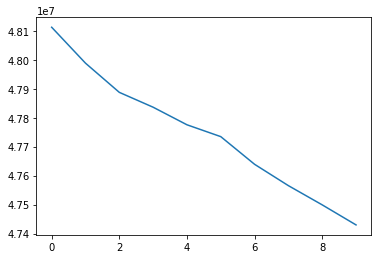

In [324]:
plt.plot(losses)